<img src="./logo_UTN.svg" align="right" width="150" /> 

#### Procesamiento Digital de Señales

# Trabajo Práctico Nº4
#### Mathilde d'Hébrail





### Configuracion e inicio de la simulacion

In [63]:
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20,10)
import matplotlib.pyplot as plt
import scipy.signal as sig
import warnings
warnings.filterwarnings('ignore')
import math
from math import *

#%% Esto tiene que ver con cuestiones de presentación de los gráficos,
# NO ES IMPORTANTE
fig_sz_x = 14
fig_sz_y = 13
fig_dpi = 80 # dpi
fig_font_size = 16
plt.rcParams.update({'font.size':fig_font_size})
 

# Datos generales de la simulación
fs = 1000 # frecuencia de muestreo (Hz)
N = 1000   # cantidad de muestras
 
# cantidad de veces más densa que se supone la grilla temporal para tiempo "continuo"
over_sampling = 4
N_os = N*over_sampling
 
# Datos del ADC
B = 4 # bits
Vf = 2 # Volts
q = Vf/(2**B) # Volts

# Datos del señal senoidal
vmax = 1 #amplitud maximal de la senoidal (volts)
dc = 0 #valor medio (volts)
ph = 0 #fase (radianes)
 
# datos del ruido
kn = 10
pot_ruido = ((q**2)/12) * kn # Watts (potencia de la señal 1 W)
 
ts = 1/fs # tiempo de muestreo
df = fs/N # resolución espectral
df_os = fs/N_os

### Creacion de un señal senoidal:

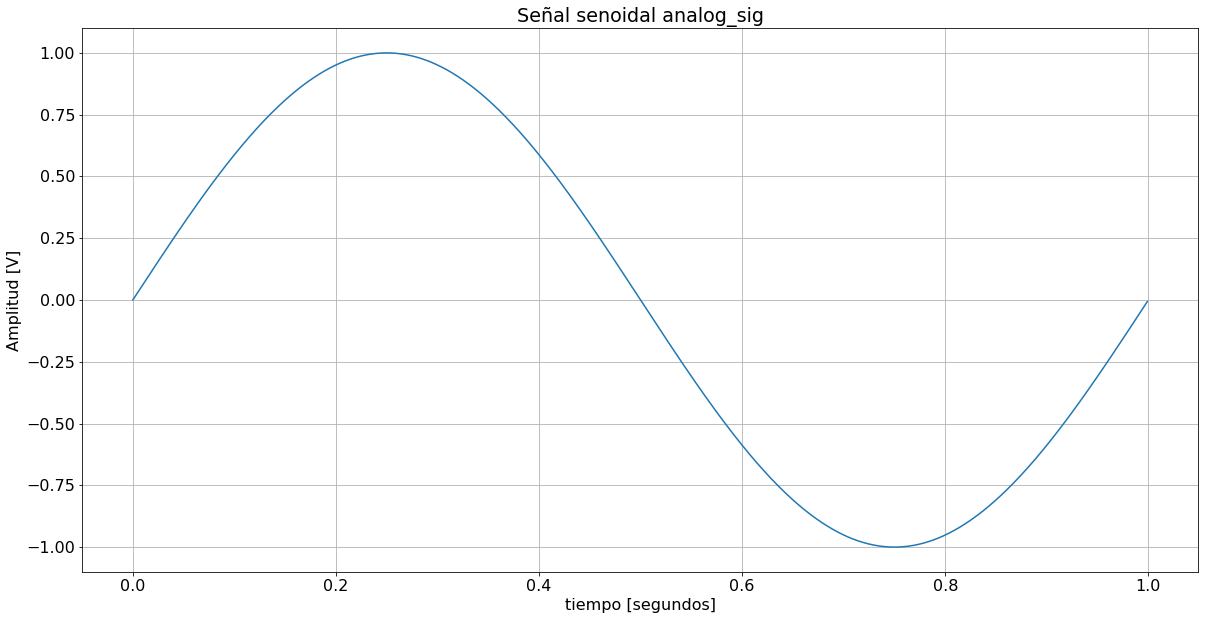

In [64]:
#Funcion para generar un señal senoidal
def mi_funcion_sen( vmax, dc, ff, ph, nn, fs ):
    
    ts = 1/fs # tiempo de muestreo
    df = fs/nn # resolución espectral
    
    # grilla de sampleo temporal
    tt = np.linspace(0, (N-1)*ts, N).flatten()
    
    # guardaremos las señales creadas al ir poblando la siguiente matriz vacía
    x = np.array([], dtype=np.float).reshape(N,0)
    
    aux = dc + vmax * np.sin( 2*np.pi*ff*tt + ph )
    xx = aux.reshape(N,1)
    
    return tt, xx.flatten()


#Creation del señal
tt_os, analog_sig = mi_funcion_sen( vmax, dc, df, ph, N_os, fs)  

# Presentación gráfica del señal
plt.figure(1)
line_hdls = plt.plot(tt_os, analog_sig)
plt.title('Señal senoidal analog_sig' )
plt.xlabel('tiempo [segundos]')
plt.ylabel('Amplitud [V]')
plt.grid(which='both', axis='both')
plt.show()

### Creation del señal ruidoso a partir del señal senoidal, y quantizacion sobre 4 bits

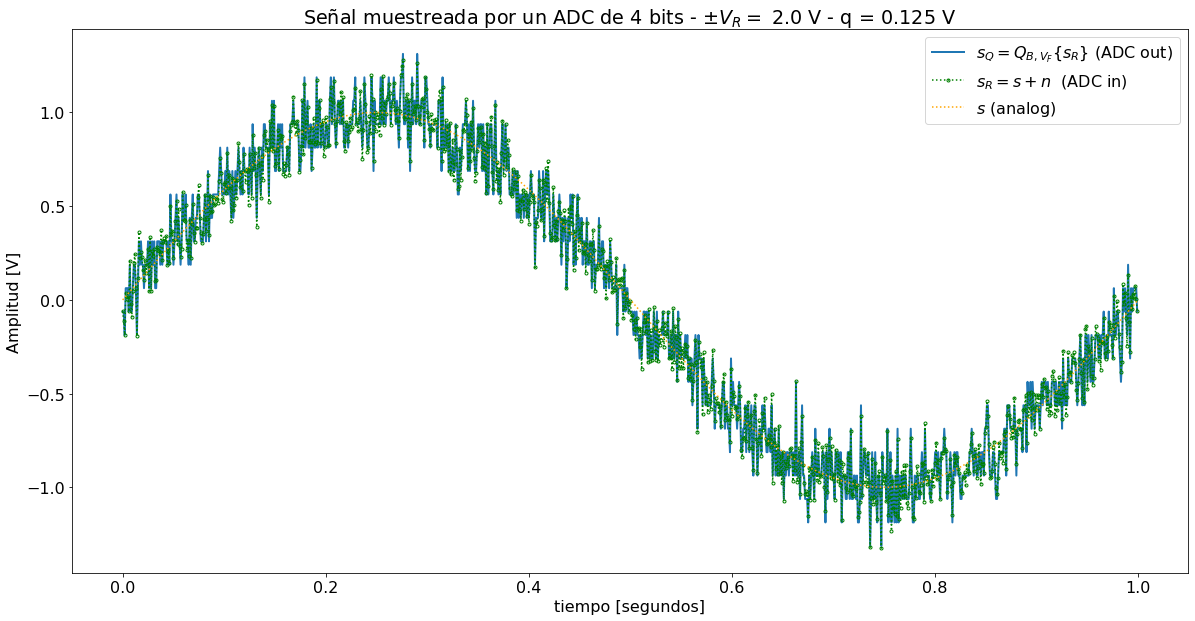

In [65]:
def agregar_ruido(xx, varianza):
    ruido = np.random.normal(0, np.sqrt(varianza), xx.shape)
    xx_ruidosa = xx + ruido
    return xx_ruidosa

sr = agregar_ruido(analog_sig, pot_ruido)
ruido = sr - analog_sig


def quantizacion(xx, B, Vf):
    xx_quantizado =  np.round((xx-q/2)*(1/q))*q + q/2
    return xx_quantizado

srq = quantizacion(sr, B, Vf)
nq = srq - sr   # ruido de quantizacion


tt = np.linspace(0, (N-1)*ts, N).flatten()



#%% Presentación gráfica de los resultados
plt.close('all')
 
plt.figure(1)
plt.plot(tt, srq, lw=2, label='$ s_Q = Q_{B,V_F}\{s_R\} $ (ADC out)')
plt.plot(tt, sr, linestyle=':', color='green',marker='o', markersize=3, markerfacecolor='none', markeredgecolor='green', fillstyle='none', label='$ s_R = s + n $  (ADC in)')
plt.plot(tt_os, analog_sig, color='orange', ls='dotted', label='$ s $ (analog)')
 
plt.title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q) )
plt.xlabel('tiempo [segundos]')
plt.ylabel('Amplitud [V]')
axes_hdl = plt.gca()
axes_hdl.legend()
plt.show()

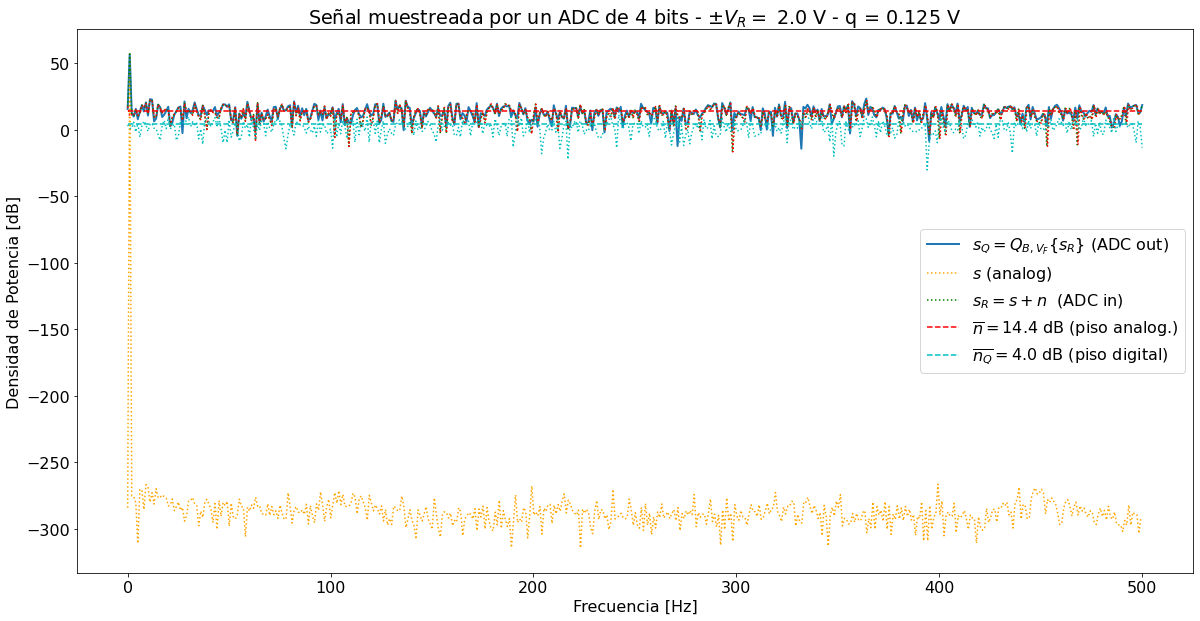

In [66]:
ft_As = np.fft.fft(analog_sig, axis = 0).flatten()
ft_SR = np.fft.fft(sr, axis = 0).flatten()
ft_Srq = np.fft.fft(srq, axis = 0).flatten()
ft_Nn = np.fft.fft(ruido, axis = 0).flatten()
ft_Nq = np.fft.fft(nq, axis = 0).flatten()

ff = np.linspace(0, (N-1)*df, fs).flatten()
ff_os = np.linspace(0, (N_os-1)*df_os, fs).flatten()


# Oresentacion graphica de los resultados
plt.figure(2)
bfrec = ff <= fs/2  #select all the frequencies below fs/2
 
Nnq_mean = np.mean(np.abs(ft_Nq)**2)
nNn_mean = np.mean(np.abs(ft_Nn)**2)


plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Srq[bfrec])**2), lw=2, label='$ s_Q = Q_{B,V_F}\{s_R\} $ (ADC out)' )
plt.plot( ff_os[ff_os <= fs/2], 10* np.log10(2*np.abs(ft_As[ff_os <= fs/2])**2), color='orange', ls='dotted', label='$ s $ (analog)' )
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_SR[bfrec])**2), ':g', label='$ s_R = s + n $  (ADC in)' )
plt.plot( ff_os[ff_os <= fs/2], 10* np.log10(2*np.abs(ft_Nn[ff_os <= fs/2])**2), ':r')
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Nq[bfrec])**2), ':c')
plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([nNn_mean, nNn_mean]) ), '--r', label= '$ \overline{n} = $' + '{:3.1f} dB (piso analog.)'.format(10* np.log10(2* nNn_mean)) )
plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([Nnq_mean, Nnq_mean]) ), '--c', label='$ \overline{n_Q} = $' + '{:3.1f} dB (piso digital)'.format(10* np.log10(2* Nnq_mean)) )
plt.title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q) )
plt.ylabel('Densidad de Potencia [dB]')
plt.xlabel('Frecuencia [Hz]')
axes_hdl = plt.gca()
axes_hdl.legend()
# suponiendo valores negativos de potencia ruido en dB
#plt.ylim((1.5*np.min(10* np.log10(2* np.array([Nnq_mean, nNn_mean]))),10))

Si ampliamos mucho, tenemos esto.

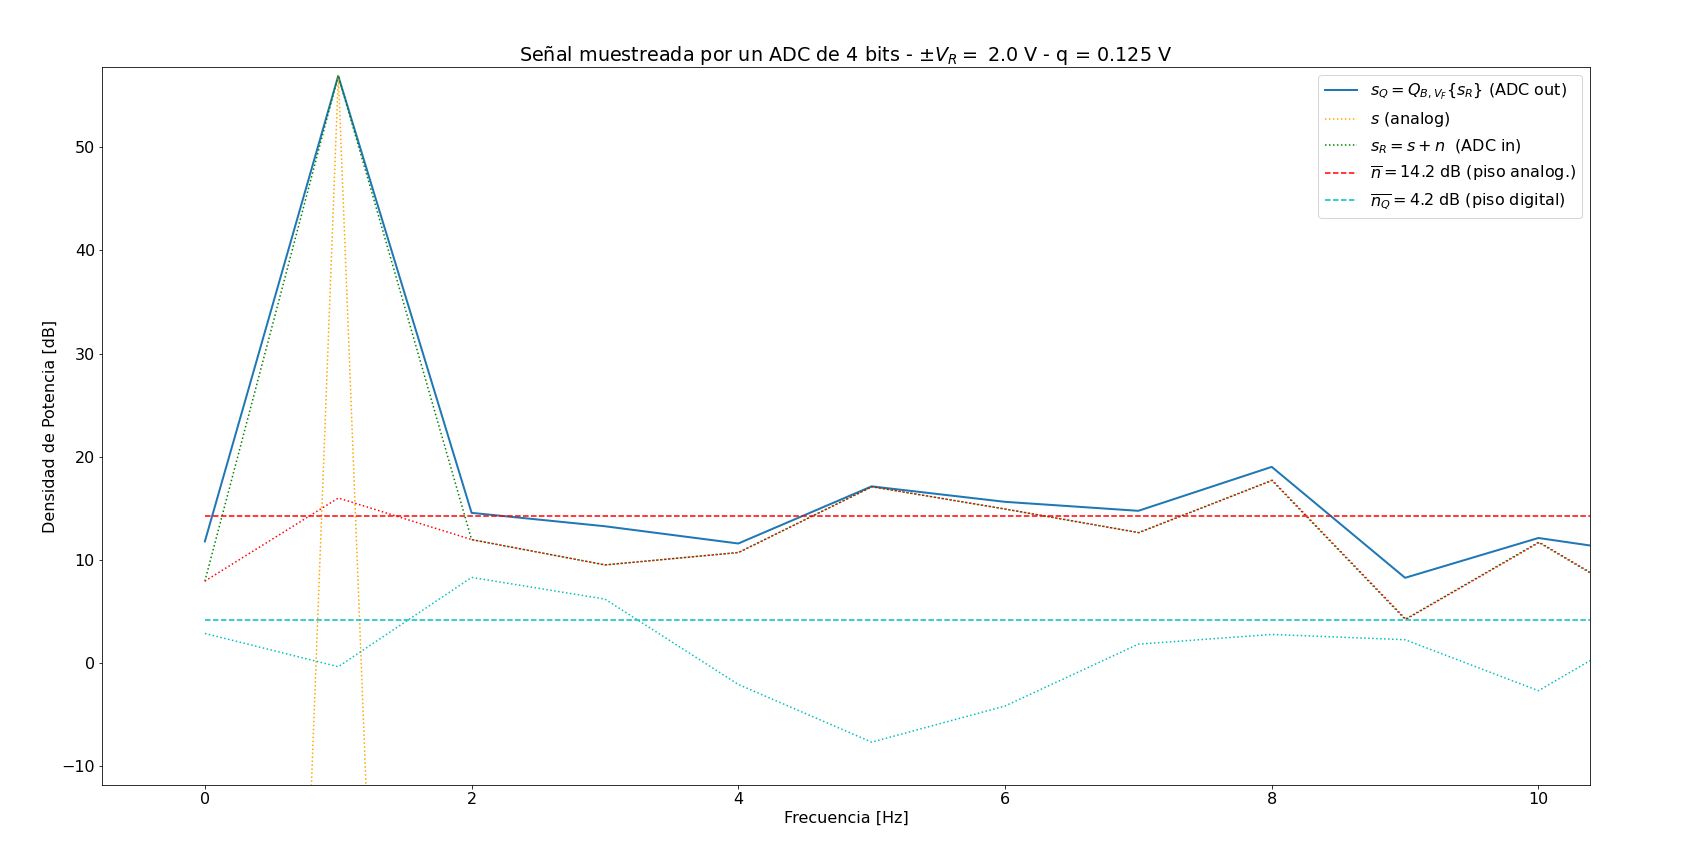

Podemos ver que el señal verde, sr, que es el señal ruidoso no quantizado, a partir de una cierta frecuencia, està cuasi igual al ruido, porque el señal senoidal solo tiene una frequencia por definicion.  
Lo mas interesante aqui es observar que el ruido de quantizacion es debajo del ruido analogo. Este ruido de quantizacion se agrega al ruido analogo. El señal quantizado (azul) es la suma del señal señoidal, del ruido analogo, y del ruido de quantizacion.
Si habiamos puesto k = 1, poniendo la potencia del ruido analogo al igual de la potencia del ruido de quantizacion, la medias habrian sido iguales.
Y si habiamos puesto k = 1/10, poniendo la potencia del ruido analogo 10 vez menor que la potencia del ruido de quantizacion, la medias habrian sido iguales.

Text(0.5, 1.0, 'Ruido de cuantización para 4 bits - $\\pm V_R= $ 2.0 V - q = 0.125 V')

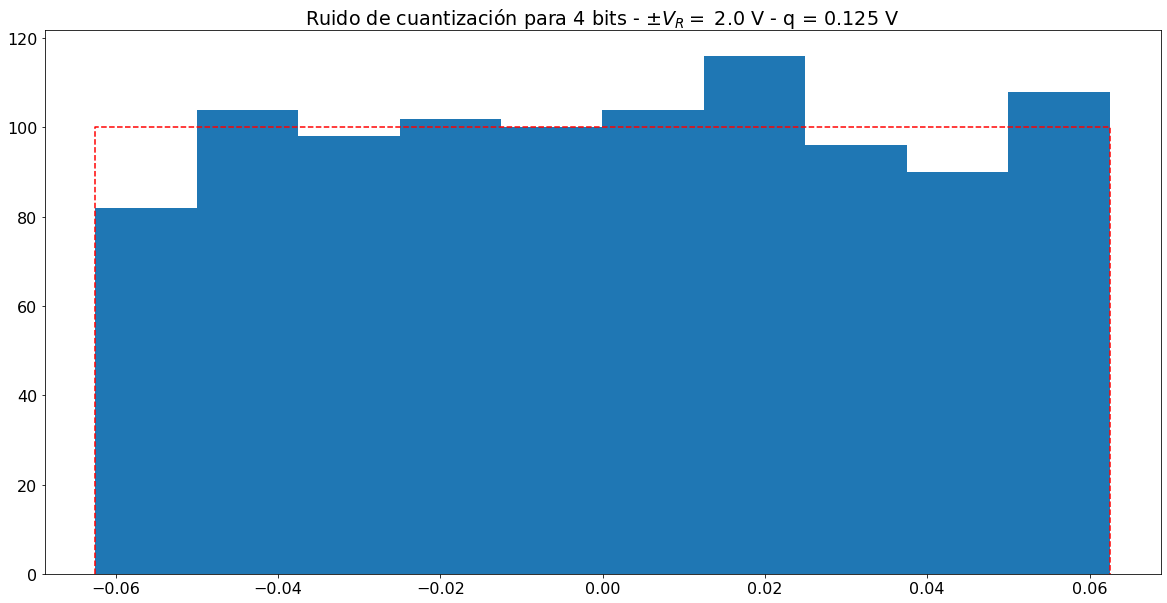

In [67]:
plt.figure(3)
bins = 10
plt.hist(nq, bins=bins)
plt.plot( np.array([-q/2, -q/2, q/2, q/2]), np.array([0, N/bins, N/bins, 0]), '--r' )
plt.title( 'Ruido de cuantización para {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q))

Este grafica nos muestra que el ruido de cuantizacion no sigue una distribucion normal como el ruido analogo, pero una distribucion uniforme.